## 4 . EVALUATION METRICS

Let's train the model again first - to use its results later in this notebook

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [10]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

### 4.1 Accuracy and Dummy Models

Evaluate the model on different thresholds<br>
Check the accuracy of the dummy baselines

In [11]:
len(y_val)

1409

In [12]:
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
# Here the churn_decision is taken at 50%, now we can calculate this on multiple threshold

threshold = np.linspace(0, 1, 21)

scores = []

for t in threshold:
    # churn_decision = (y_pred >= t)
    # score = (y_val == churn_decision).mean()   this is our own formula, instead we can you from sklearn
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


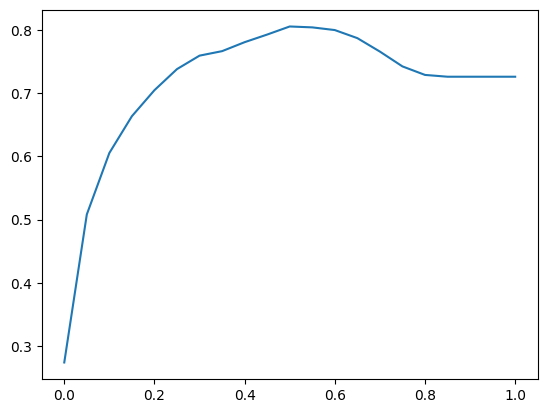

In [15]:
plt.plot(threshold, scores)

In [16]:
from collections import Counter

In [17]:
1 - y_val.mean()

np.float64(0.7260468417317246)

### 4.2 Confussion table

Different types of errors and correct decision<br>
Arranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
tp = (predict_positive & actual_positive).sum() # tp = True Positive
tn = (predict_negative & actual_negative).sum() # tn = True Negative

In [21]:
tp , tn

(np.int64(212), np.int64(923))

In [22]:
fp = (predict_positive & actual_negative).sum() # fp = False Positive
fn = (predict_negative & actual_positive).sum() # fn = False Negative

In [23]:
fp, fn

(np.int64(100), np.int64(174))

In [24]:
confusion_matrix = np.array(
     # predict neg    pos
    [[tn, fp], # actual neg
     [fn, tp]]) # actual pos

confusion_matrix

array([[923, 100],
       [174, 212]])

In [25]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

### 4.3 Precision and Recall

In [26]:
(tp + tn)/ (tp + tn + fp + fn)

np.float64(0.8055358410220014)

In [27]:
p = tp / (tp + fp)
p # precision

np.float64(0.6794871794871795)

In [28]:
tp+ fp

np.int64(312)

In [29]:
r = tp / (tp + fn)
r # recall

np.float64(0.5492227979274611)

In [30]:
tp + fn

np.int64(386)

In [31]:
# So from this, we can see that accuracy is not the best matrics to evaluate this model in this senario
# The model failed to identify almost 45% of people going to churn and also sent additional offers for 32 % non-churning people

### 4.4 ROC Curve

#### TPR and FRP

In [32]:
# True Positive Rate 

trp = tp / (tp + fn)
# this vlaue is equal to recall value

In [33]:
# False Positive Rate

frp = fp / (fp + tn)

In [34]:
# Now lets find all these values at different threshold

threshold = np.linspace(0 , 1, 101)

scores = []

for t in threshold:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum() 
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum() 
    fn = (predict_negative & actual_positive).sum() 

    scores.append((t, tp, fp, tn, fn))

In [35]:
columns = ['threshold', 'tp', 'fp', 'tn', 'fn']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

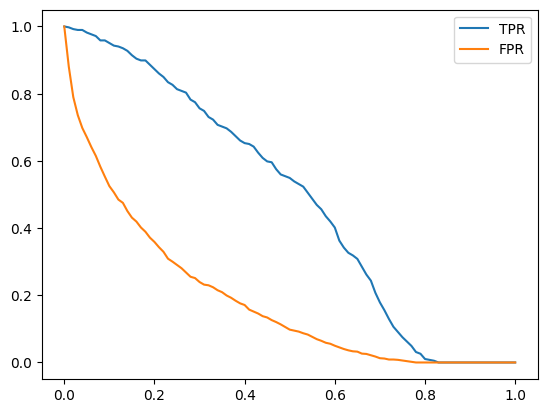

In [36]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

#### Random Model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size = len(y_val))

In [38]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089], shape=(1409,))

In [39]:
def tpr_fpr_dataframe(y_val, y_pred):
    threshold = np.linspace(0 , 1, 101)

    scores = []

    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum() 
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum() 
        fn = (predict_negative & actual_positive).sum() 

        scores.append((t, tp, fp, tn, fn))

    columns = ['threshold', 'tp', 'fp', 'tn', 'fn']
    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [41]:
df_rand[::10]

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,100,39,0.898964,0.902248
20,0.2,307,822,201,79,0.795337,0.803519
30,0.3,276,724,299,110,0.715026,0.707722
40,0.4,237,624,399,149,0.613990,0.609971
50,0.5,202,518,505,184,0.523316,0.506354
60,0.6,161,409,614,225,0.417098,0.399804
70,0.7,121,302,721,265,0.313472,0.295210
80,0.8,78,206,817,308,0.202073,0.201369
90,0.9,40,101,922,346,0.103627,0.098729


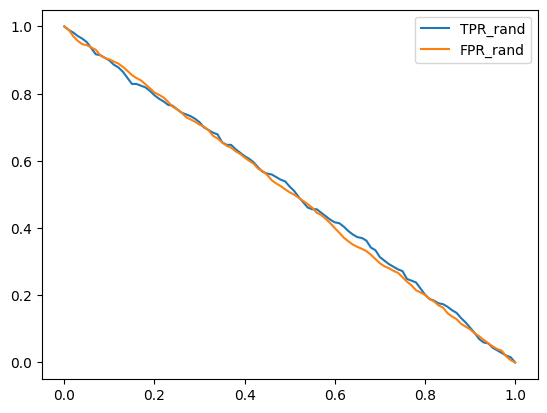

In [42]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR_rand')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR_rand')
plt.legend()

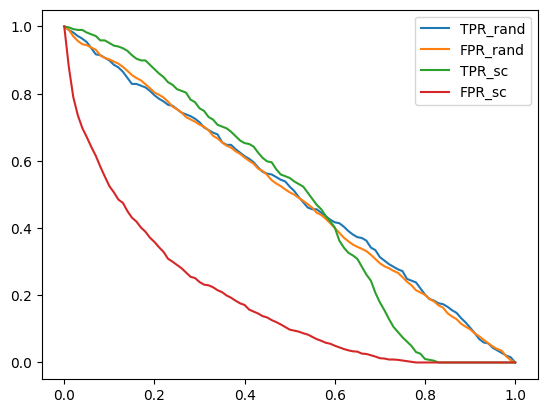

In [43]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR_rand')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR_rand')
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR_sc')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR_sc')
plt.legend()

#### Ideal Model

In [44]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [45]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [46]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [47]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [48]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

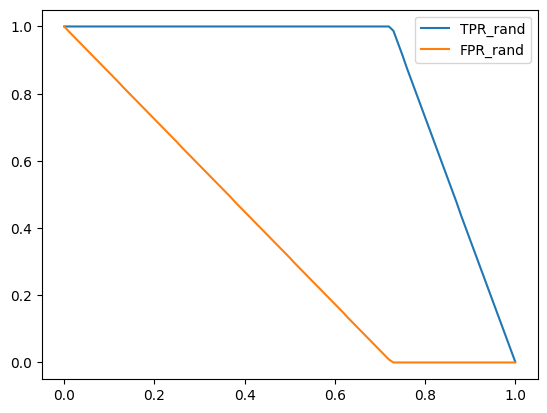

In [49]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR_rand')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR_rand')
plt.legend()

#### Putting everything together

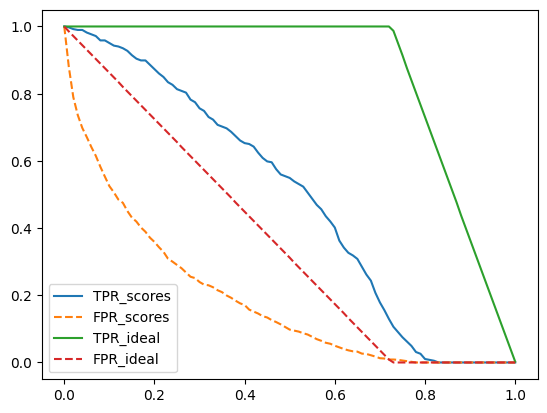

In [50]:
#plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR_rand')
#plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR_rand')
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR_scores')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR_scores', linestyle='--')
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR_ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR_ideal', linestyle='--')
plt.legend()

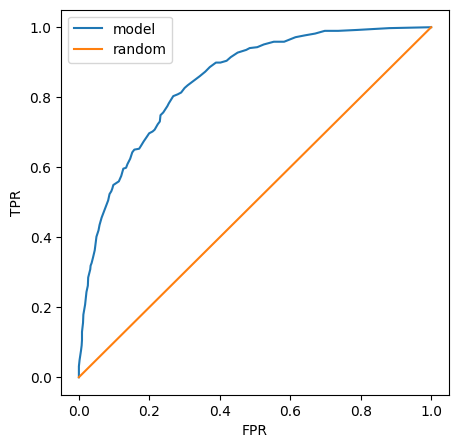

In [51]:
plt.figure(figsize=(5,5))
 
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

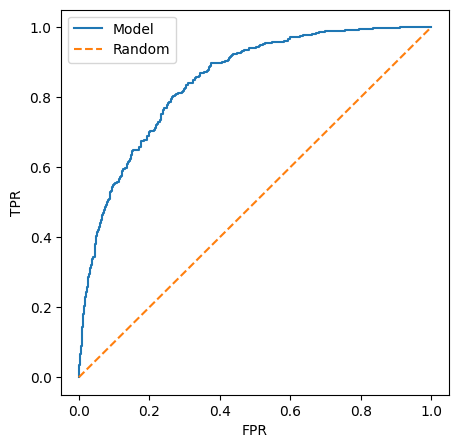

In [52]:
# We can also use the ROC functionality of scikit learn package
from sklearn.metrics import roc_curve
 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
 
plt.figure(figsize=(5,5))
 
plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

### 4.5 ROC AUC – Area under the ROC curve

Useful metric<br>
Interpetation of AOC

In [53]:
from sklearn.metrics import auc

In [54]:
auc(fpr, tpr)

0.8465981898206534

In [55]:
auc(df_scores.fpr, df_scores.tpr)

0.8463208889834327

In [56]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [57]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8465981898206534

In [58]:
# Now we can find the area under the ROC Courve using a function from sklearn

from sklearn.metrics import roc_auc_score

In [59]:
roc_auc_score(y_val, y_pred)

0.8465981898206534

In [60]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [61]:
import random
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)

In [62]:
pos[pos_ind] > neg[neg_ind]

np.True_

In [63]:
n = 100000
success = 0
 
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
 
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
 
success / n

0.84627

In [64]:
n = 50000
 
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
pos[pos_ind] > neg[neg_ind]
 
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84892)

### 4.6 Cross Validation - KFold

Evaluating the same model on  different subsets of data<br>
Getting the avarage prediction and spread within the prediction

In [65]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression()
    model.fit(X_train, y_train)
 
    return dv, model

In [66]:
dv, model = train(df_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
def predict(df, dv, model):
     dicts = df_train[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [68]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.08911312, 0.66871172, 0.63770441, ..., 0.51223683, 0.03006521,
       0.7028991 ], shape=(4225,))

In [69]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1) 
 
next(kfold.split(df_train_full))

(array([   0,    1,    2, ..., 5631, 5632, 5633], shape=(5070,)),
 array([   4,   21,   28,   33,   44,   58,   67,   72,   79,   81,   82,
          98,  101,  116,  119,  125,  126,  136,  141,  147,  161,  169,
         179,  192,  196,  200,  206,  214,  222,  231,  250,  255,  259,
         276,  280,  285,  301,  308,  313,  314,  325,  343,  354,  359,
         383,  386,  407,  420,  428,  433,  440,  447,  457,  473,  486,
         496,  501,  503,  507,  545,  554,  557,  566,  574,  580,  582,
         592,  605,  608,  623,  634,  636,  645,  662,  667,  684,  687,
         689,  729,  745,  758,  763,  778,  783,  792,  795,  808,  839,
         840,  847,  850,  858,  867,  870,  871,  881,  899,  906,  927,
         929,  931,  940,  943,  976,  984,  987,  988, 1005, 1016, 1028,
        1034, 1038, 1050, 1056, 1074, 1079, 1117, 1122, 1123, 1131, 1134,
        1139, 1144, 1155, 1159, 1163, 1169, 1179, 1198, 1206, 1216, 1238,
        1247, 1256, 1272, 1297, 1298, 1310, 13

In [70]:
train_idx, val_idx = next(kfold.split(df_train_full))
len(train_idx), len(val_idx)

(5070, 564)

In [71]:
len(df_train_full)

5634

In [72]:
df_train = df_train_full.iloc[train_idx]
df_val = df_train_full.iloc[val_idx]

In [74]:
len(y_val), len(y_pred)

(564, 5070)

In [73]:
# Now we use roc_auc_score to to calculate and output the score

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Found input variables with inconsistent numbers of samples: [564, 5070]

In [ ]:
# Same implimentation with tqdm

from sklearn.model_selection import KFold
!pip3 install tqdm
from tqdm.auto import tqdm
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in tqdm(kfold.split(df_train_full)):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [ ]:
scores